In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
data = pd.read_csv('p3_2moons.csv')
data

,x,y,class
0,-0.036420,0.425192,1
1,1.004359,-0.439032,1
2,0.885975,-0.315673,1
3,0.333107,-0.422853,1
4,-0.837682,0.532822,0
...,...,...,...
995,0.804351,0.550142,0
996,-0.153885,0.932474,0
997,1.673422,-0.328071,1
998,-0.955380,0.295783,0


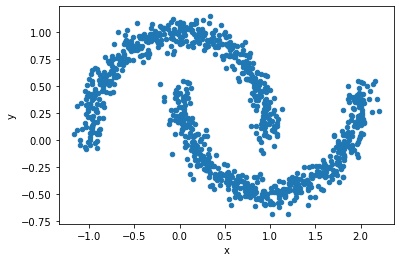

In [4]:
data.plot.scatter(x='x', y='y')
plt.show()

Most accurate parameters

              Num Neighbors  Accuracy
test_size_0.1   num_neigh_1       1.0
test_size_0.2   num_neigh_1       1.0
test_size_0.3   num_neigh_1       1.0
test_size_0.4   num_neigh_1       1.0
test_size_0.5   num_neigh_1       1.0
test_size_0.6   num_neigh_1       1.0
test_size_0.7   num_neigh_1       1.0
test_size_0.8   num_neigh_1       1.0
test_size_0.9   num_neigh_2       1.0


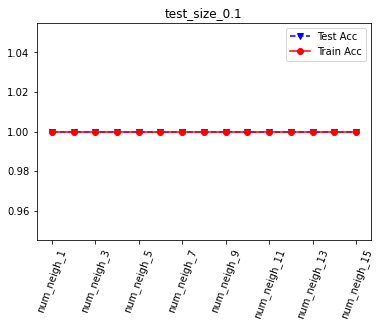

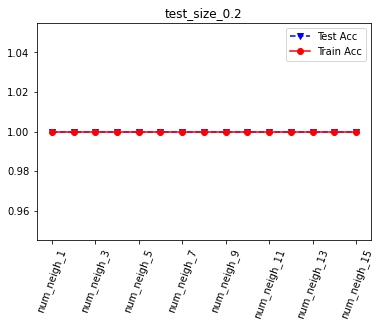

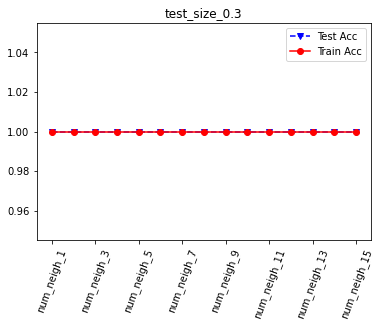

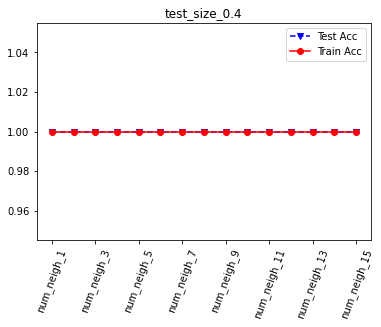

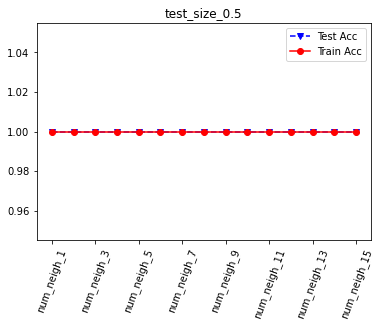

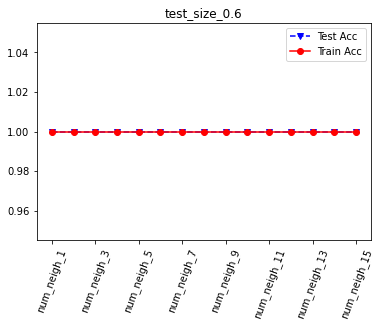

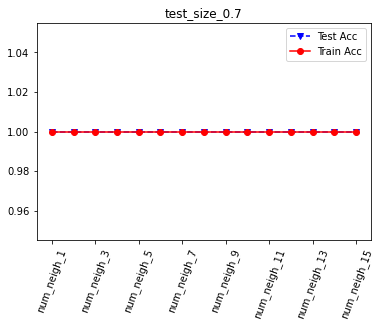

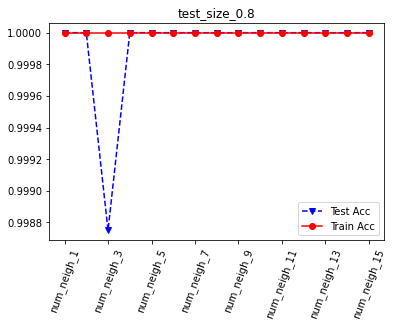

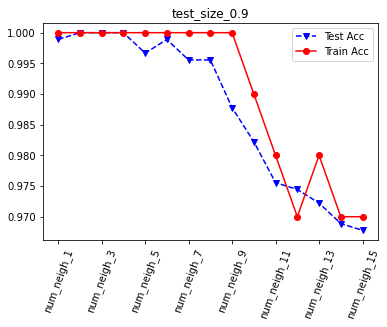

In [11]:
from sklearn.neighbors import KNeighborsClassifier
X = data[['x', 'y']]
Y = data['class']


test_sizes = [i/10 for i in range(1,10)]
numNeighbors = [i for i in range(1,16)]

train = {'test_size_{}'.format(size):{} for size in test_sizes}
test = {'test_size_{}'.format(size):{} for size in test_sizes}

for size in test_sizes: #loop through different split sizes
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=size, random_state=1)

    for k in numNeighbors: #loop through param size
        if k >= len(X_train): #check if the neighborhood size is larger than the size of the data
            train['test_size_{}'.format(size)]['num_neigh_{}'.format(k)] = np.nan
            test['test_size_{}'.format(size)]['num_neigh_{}'.format(k)] = np.nan
            continue
        # train the model usign brute force since we have a small number of obs
        clf = KNeighborsClassifier(n_neighbors=k, algorithm='brute' , metric='minkowski', p=2)
        clf.fit(X_train, Y_train)
        Y_predTrain = clf.predict(X_train)
        Y_predTest = clf.predict(X_test)
        #save the accuracy of the params
        train['test_size_{}'.format(size)]['num_neigh_{}'.format(k)] = accuracy_score(Y_train, Y_predTrain)
        test['test_size_{}'.format(size)]['num_neigh_{}'.format(k)] = accuracy_score(Y_test, Y_predTest)

# convert to dataframes
test= pd.DataFrame(test)
train = pd.DataFrame(train)

# get the max of each row and each column 
print('Most accurate parameters\n')
print(pd.concat([test.idxmax(), test.max()], axis=1).rename({0:'Num Neighbors', 1:'Accuracy'}, axis='columns'))

# plot each column 
for col in test.columns:
    fig, ax = plt.subplots()
    test[col].plot(ax=ax, label='Test Acc', style='bv--')
    train[col].plot(ax=ax, label='Train Acc', style='ro-')
    plt.legend()
    plt.xticks(rotation=70)
    plt.title(col)


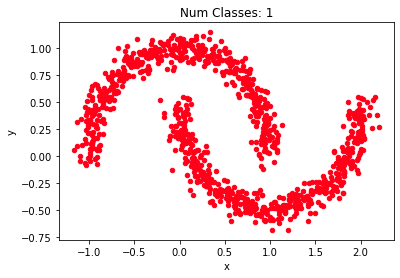

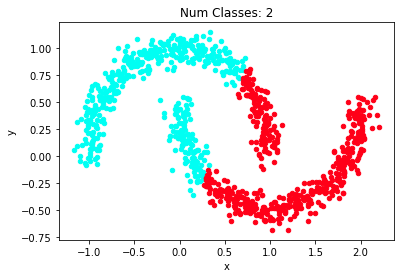

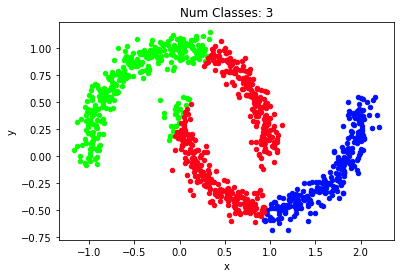

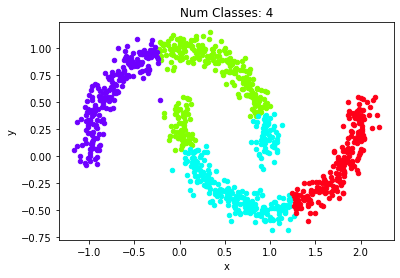

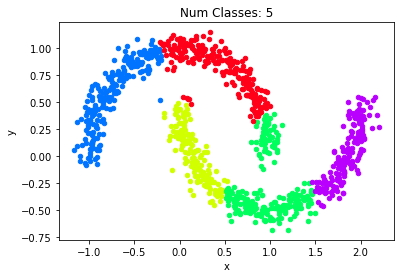

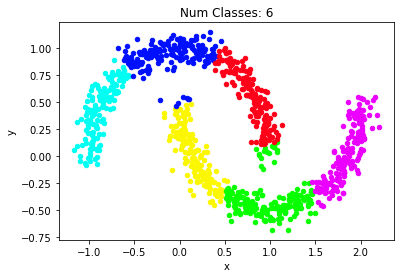

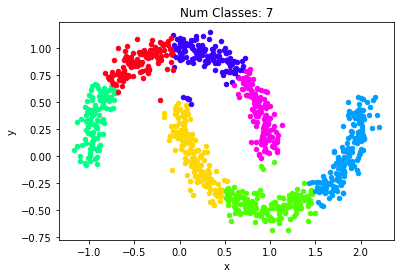

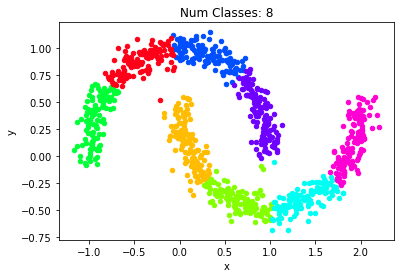

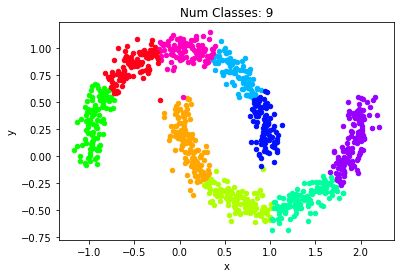

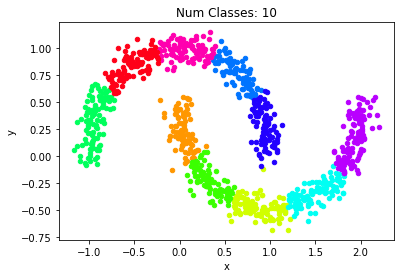

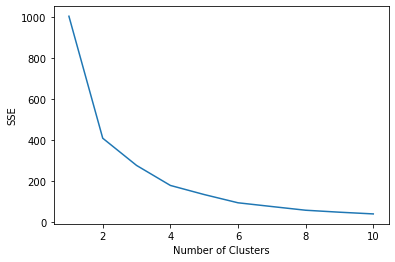

In [6]:
from sklearn import cluster
%matplotlib inline
_data = data.drop('class',axis=1)
err = []
for num_neighbors in range(1,11):
    
    k_means = cluster.KMeans(n_clusters=num_neighbors, max_iter=100, random_state=1)
    k_means.fit(_data) 
    err.append(k_means.inertia_)
    
    _data['Pred'] = k_means.labels_

    output_classes = _data['Pred'].unique()

    colors = plt.cm.get_cmap('hsv', len(output_classes)+1)

    fig, ax = plt.subplots()
    
    for i, cls in enumerate(output_classes):
        _data[_data['Pred']==cls].plot.scatter('x', 'y', color=colors(i+1), ax=ax)
    plt.title('Num Classes: {}'.format(num_neighbors))
    plt.show()
    _data = _data.drop('Pred', axis=1)

    
fig, ax = plt.subplots()
ax.plot(range(1,11),err)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

I wanted see what would happen when I increased the number of clusters with this algorithm. Unsurpisingly, it split the data into the corresponding number of classes. The SSE did decrease as the number of clusters increased, but these models were less accurate as the number of true classes was only 2. Visualizing the data as the number of classes increased helped me better understand what splits the algorithm made. It seems like when it was specified that there were only two classes, the data was split by a straight line. To me, when looking at the SSE graph, it seems that the elbow is around the 4 clusters mark which is interesting because we know there are only two real clusters of data. It is also very interesting that this unsupervised method produces poorer final models than the supervised KNN model. I believe that is becuase the model really has no way of understanding what clusters you truly want to identify and instead just clusters the data the best it can to the number of classes you want.  

In [17]:
from sklearn.cluster import DBSCAN
_data = data.drop('class', axis=1)

min_clusters = {i/100:{j:np.nan for j in range(1,16)} for i in range(1,51)}

for i in range(1,51):
    for j in range(1,16):
        db = DBSCAN(eps=i/100, min_samples=j).fit(_data)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = pd.DataFrame(db.labels_,columns=['Cluster ID'])
        min_clusters[i/100][j] = len(labels['Cluster ID'].unique())
    
num_clusters = pd.DataFrame(min_clusters)

In [18]:
print('Parameters that yielded two output clusters.\n'.center(75))
for col in num_clusters.columns:
    target_clusters = num_clusters[num_clusters[col] == 2].index
    if len(target_clusters):
        print('='*75)
        print('Neighborhood size:',col) 
        print('Min Samples:',target_clusters.values)
print('='*75)

               Parameters that yielded two output clusters.
               
Neighborhood size: 0.02
Min Samples: [7]
Neighborhood size: 0.03
Min Samples: [ 9 10]
Neighborhood size: 0.04
Min Samples: [11]
Neighborhood size: 0.17
Min Samples: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Neighborhood size: 0.18
Min Samples: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Neighborhood size: 0.19
Min Samples: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Neighborhood size: 0.2
Min Samples: [13 14 15]
Neighborhood size: 0.21
Min Samples: [13 14 15]
Neighborhood size: 0.22
Min Samples: [13 14 15]


From experimenting with the parameters of the DBSCAN algorithm, it was discovered that there are several inputs that will result in splitting the data into the original two clusters. The output of the cell above shows which splits provided the "perfect output" for this training data. Overall, the most optimal splits for the model was setting the neighborhood size from .17 to .19 and any number of samples in that range would produce a model with two output classes. 

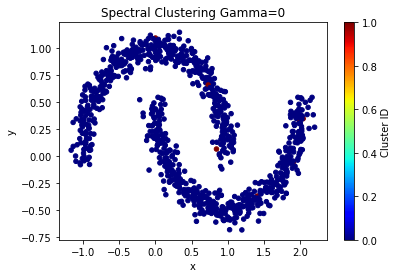

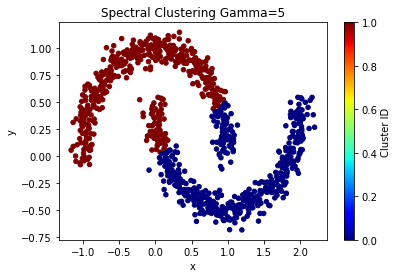

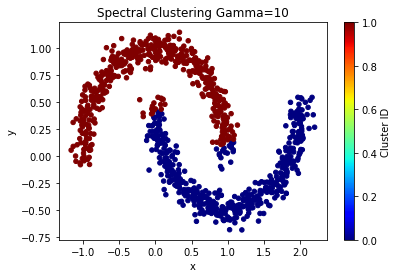

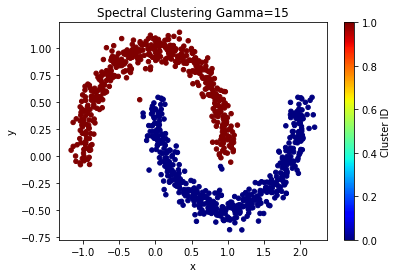

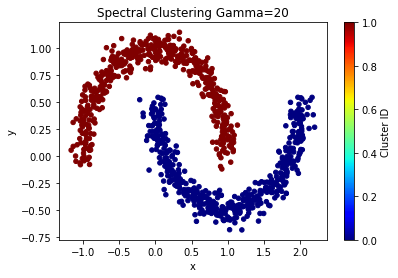

In [16]:
_data = data.drop('class', axis=1)

for i in range(0, 21, 5):
    spectral = cluster.SpectralClustering(n_clusters=2,random_state=1,affinity='rbf',gamma=i)
    spectral.fit(_data)
    labels1 = pd.DataFrame(spectral.labels_,columns=['Cluster ID'])
    result1 = pd.concat((_data,labels1), axis=1)

    fig, ax = plt.subplots()
    result1.plot.scatter(x='x',y='y',c='Cluster ID',colormap='jet',ax=ax)
    ax.set_title('Spectral Clustering Gamma={}'.format(i))

Using the spectral clustering method, I tried varying the input for the gamma parameter and found that to split the data into two seperate clusters a gamma of at least 20 will work. 

Overall, it seems to me that the Spectral Clustering alogoritm required the least tuning for this particular dataset. I believe that this is becuase of the inherent nature of the K-means algorithm when it comes to classifying data like this. The DBSCAN algorithm also performed well on this dataset, but required slightly more fine tuning than the Spectral Clustering algorithm. Finding the appropriate neighborhood size along with the appropriate number of samples proved to be somewhat difficult or at the very least more difficult than the Spectral Clustering. The only parameter that needed to be changed for this dataset for the Spectral algorithm was the gamma value and it had to be changed very slightly. 